<a href="https://colab.research.google.com/github/krchnst/UserBehavior_Analytics/blob/main/UserBehavior_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import auth
from google.cloud import bigquery

In [ ]:
auth.authenticate_user()
client = bigquery.Client(project="data-analytics-mate")

In [ ]:
query = """
WITH s AS(
  select ga_session_id,
         DATE(date) AS session_date
  from `data-analytics-mate.DA.session`
),

sp AS(
  select ga_session_id,
         continent,
         country,
         device,
         browser,
         mobile_model_name,
         operating_system,
         language,
         medium,
         name,
         channel
  FROM `data-analytics-mate.DA.session_params`
),
acct AS (
  SELECT
         id AS account_id,
         CAST(is_verified AS INT64)     AS is_email_verified,
         CAST(is_unsubscribed AS INT64) AS is_unsubscribed
  FROM `data-analytics-mate.DA.account`
),
p AS (
  SELECT
         item_id,
         category,
         name  AS product_name,
         price,
         short_description
  FROM `data-analytics-mate.DA.product`
),
as_map AS (
  SELECT account_id, ga_session_id
  FROM (
    SELECT
      account_id, ga_session_id,
      ROW_NUMBER() OVER (PARTITION BY ga_session_id ORDER BY account_id) AS rn
    FROM `data-analytics-mate.DA.account_session`
  )
  WHERE rn = 1
),
o AS (
  SELECT ga_session_id, item_id
  FROM `data-analytics-mate.DA.order`
)

SELECT s.session_date AS order_date,
       s.ga_session_id,
       sp.continent,
       sp.country,
       sp.device,
       sp.browser,
       sp.mobile_model_name,
       sp.operating_system,
       sp.language,
       sp.medium AS traffic_medium,
       sp.name AS traffic_source_name,
       sp.channel AS traffic_channel,
       as_map.account_id,
       acct.is_email_verified,
       CAST(1 - acct.is_unsubscribed AS INT64) AS is_subscribed,
       p.category AS product_category,
       p.product_name,
       p.price,
       p.short_description
FROM s
LEFT JOIN sp
ON sp.ga_session_id = s.ga_session_id
LEFT JOIN as_map
ON as_map.ga_session_id = s.ga_session_id
LEFT JOIN acct
ON acct.account_id = as_map.account_id
LEFT JOIN o
ON o.ga_session_id = s.ga_session_id
LEFT JOIN p
ON p.item_id = o.item_id
"""

query_job = client.query(query)  # Виконання SQL-запиту
results = query_job.result()  # Очікування завершення запиту

In [ ]:
df = results.to_dataframe()
print(df)

        order_date  ga_session_id continent        country   device  \
0       2020-11-01      967742695  Americas  United States  desktop   
1       2020-11-01     9065007548      Asia          China  desktop   
2       2020-11-01     3267062634  Americas  United States  desktop   
3       2020-11-01     8892952409  Americas  United States   mobile   
4       2020-11-01     1624570787      Asia         Turkey  desktop   
...            ...            ...       ...            ...      ...   
349540  2021-01-31      830102441  Americas  United States  desktop   
349541  2021-01-31      167350204    Europe         Poland   mobile   
349542  2021-01-31     1587098569  Americas  United States   mobile   
349543  2021-01-31     5756982967    Europe        Ukraine  desktop   
349544  2021-01-31     7058940865    Europe         Norway  desktop   

                browser mobile_model_name operating_system language  \
0                Safari            Safari              Web    en-us   
1    

##Brief description of the dataset

In [ ]:
print(f'Number of columbs: {df.shape[1]}\n')

num_cols = df.select_dtypes(include='number').columns.tolist()
print(f'Number of int type columbs: {len(num_cols)}, \n{num_cols}\n')

cat_cols = df.select_dtypes(include=['object', 'string', 'category']).columns.tolist()
print(f'Number of categorical type columbs: {len(cat_cols)}, \n{cat_cols}\n')

df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

date_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns.tolist()
print(f'Number of datetime type columbs: {len(date_cols)}, \n{date_cols}\n')


unique_sessions = df['ga_session_id'].nunique()
print(f'Number of unique sessions: {unique_sessions}\n')

from_ = max(df['order_date'])
to_ = min(df['order_date'])
period = (from_ - to_) + pd.Timedelta(days=1)
print(f'Period: {period}\n')


has_na = df.isna().any().any()
total_na = int(df.isna().sum().sum())
print(f'Some non-mean: {'yes' if has_na else 'no'}\nNumber of none: {total_na}\n')


missing_cnt = df.isna().sum()
print(f'Columns that have the most missing values are: \naccount_id, is_email_verified, is_subscribed, product_category, product_name, price, short_description; \nbecause registered users are rare in this dataset (so account-related fields are often null), \nmany sessions have no purchase (so product fields are empty for non-buying sessions), \nthe browser language is not always reported (e.g., WebView/embedded browsers or privacy settings). \n{missing_cnt}')

desc_price = df['price'].describe()
print(f'\nDescription of price: \n{desc_price}')
print('Based on the descriptive statistics for `price`, \nthe data shows strong positive skewness because the Mean (953.30) is significantly higher than the Median (445.00). \nThis indicates that a small number of very expensive outliers (up to 9,585.00) are heavily influencing the average price, \nwhile the typical transaction value is much lower.')


Number of columbs: 19

Number of int type columbs: 5, 
['ga_session_id', 'account_id', 'is_email_verified', 'is_subscribed', 'price']

Number of categorical type columbs: 13, 
['continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'traffic_medium', 'traffic_source_name', 'traffic_channel', 'product_category', 'product_name', 'short_description']

Number of datetime type columbs: 1, 
['order_date']

Number of unique sessions: 349545

Period: 92 days 00:00:00

Some non-mean: yes
Number of none: 2343094

Columns that have the most missing values are: 
account_id, is_email_verified, is_subscribed, product_category, product_name, price, short_description; 
because registered users are rare in this dataset (so account-related fields are often null), 
many sessions have no purchase (so product fields are empty for non-buying sessions), 
the browser language is not always reported (e.g., WebView/embedded browsers or privacy settings). 
order_date    

#General data analysis

##Sales analysis by сontinent and country: calculating total revenue

In [ ]:
continent_sales = df.groupby('continent').size().sort_values(ascending=False)
print(f'Top-3 continent of number of sales: \n{continent_sales.head(3)}\n')

continent_m = df.groupby('continent')['price'].sum().sort_values(ascending=False)
print(f'Top-3 continent of earned money: \n{continent_m.head(3)}\n')

country_sales = df.groupby('country').size().sort_values(ascending=False)
print(f'Top-5 country of number of sales: \n{country_sales.head(5)}\n')

country_m = df.groupby('country')['price'].sum().sort_values(ascending=False)
print(f'Top-5 country of earned money: \n{country_m.head(5)}')

Top-3 continent of number of sales: 
continent
Americas    193179
Asia         83113
Europe       65135
dtype: int64

Top-3 continent of earned money: 
continent
Americas    17665280.0
Asia         7601298.3
Europe       5934624.2
Name: price, dtype: float64

Top-5 country of number of sales: 
country
United States     153470
India              32763
Canada             25994
United Kingdom     11003
France              6958
dtype: int64

Top-5 country of earned money: 
country
United States     13943553.9
India              2809762.0
Canada             2437921.0
United Kingdom      938317.9
France              710692.8
Name: price, dtype: float64


##Sales analysis by product category: Global comparison versus the leading country

In [ ]:
product_sales_df = df.groupby('product_category').size().sort_values(ascending=False)
print(f'Top-10 product of sales: \n{product_sales_df.head(10)} \n')

leader_country = country_sales.index[0]
sales_by_product = df[df['country'] == leader_country]

product_sales = sales_by_product.groupby('product_category').size().sort_values(ascending=False)
print(f'Top-10 product of sales in {leader_country}: \n{product_sales.head(10)} \n')

print('The product sales situation differs slightly between the global market and the leader country, the United States, \nwhere the "Lights" category enters the top 10 while "Mirrors" drops out, indicating a localized product preference.')

Top-10 product of sales: 
product_category
Bookcases & shelving units          7630
Chairs                              5952
Sofas & armchairs                   4301
Tables & desks                      2941
Beds                                2926
Cabinets & cupboards                2318
Outdoor furniture                   2229
Children's furniture                1702
Chests of drawers & drawer units    1452
Bar furniture                       1092
dtype: int64 

Top-10 product of sales in United States: 
product_category
Bookcases & shelving units          3374
Chairs                              2576
Sofas & armchairs                   1903
Beds                                1298
Tables & desks                      1248
Cabinets & cupboards                 995
Outdoor furniture                    984
Children's furniture                 752
Chests of drawers & drawer units     616
Bar furniture                        487
dtype: int64 

The product sales situation differs slightly be

##Registered User Engagement and Sales Impact


In [ ]:
registered_users = df.dropna(subset=['account_id']).drop_duplicates(subset=['account_id']).copy()
total_registered_users = len(registered_users)

verified_users = registered_users['is_email_verified'].sum()
percent_verified = (verified_users / total_registered_users) * 100
print(f'Percentage of users, who verified email: {percent_verified:.2f}%')

unsubscribed_users = registered_users[registered_users['is_subscribed'] == 0]['is_subscribed'].count()
percent_unsubscribed = (unsubscribed_users / total_registered_users) * 100
print(f'Percentage of users, who unsubscriber: {percent_unsubscribed:.2f}%\n')

sales_by_subscription = registered_users.groupby('is_subscribed').size()
print(f'We can see: subcribed users do more sales than ubsuribed\n{sales_by_subscription}')

Percentage of users, who verified email: 71.70%
Percentage of users, who unsubscriber: 16.94%

We can see: subcribed users do more sales than ubsuribed
is_subscribed
0     4735
1    23210
dtype: int64


Sales Comparison (Subscribed vs. Unsubscribed Users):
  is_subscribed  average_price
0  Unsubscribed     965.820134
1    Subscribed     921.506812


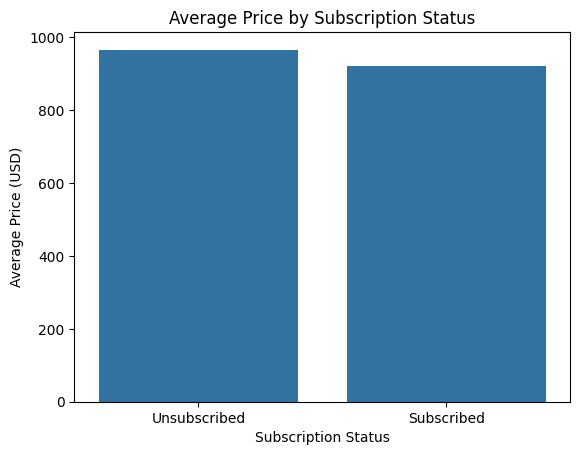

In [ ]:
registered_df = df.dropna(subset=['account_id']).copy()
sales_by_subscription = registered_df.groupby('is_subscribed').agg(
    average_price=('price', 'mean')
).reset_index()

sales_by_subscription['is_subscribed'] = sales_by_subscription['is_subscribed'].map(
    {1: 'Subscribed', 0: 'Unsubscribed'}
)

print("Sales Comparison (Subscribed vs. Unsubscribed Users):")
print(sales_by_subscription)


sns.barplot(
    x='is_subscribed',
    y='average_price',
    data=sales_by_subscription,
)
plt.title('Average Price by Subscription Status')
plt.xlabel('Subscription Status')
plt.ylabel('Average Price (USD)')
plt.show()

##Email Verification Rate by Leading Country

Top-5 country by subscribed users: country
(not set)    210
Albania        8
Algeria       20
Argentina     67
Armenia        4
Name: account_id, dtype: Int64


Percentage of verified emails in top 5 countries:
           percent_verified
country                    
Albania               100.0
Argentina         76.119403
Algeria                75.0
Armenia                75.0
(not set)         71.904762


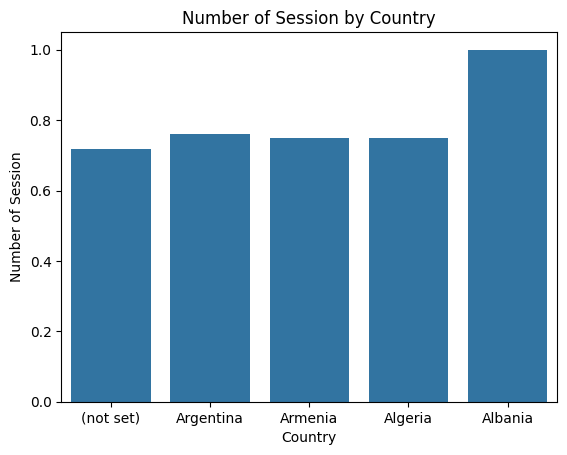

In [ ]:
registered_users = df.dropna(subset=['account_id']).drop_duplicates(subset=['account_id']).copy()

country_subscribed = registered_users.groupby('country')['account_id'].size()
print(f'Top-5 country by subscribed users: {country_subscribed.head(5)}\n')

top_5_country_names = country_subscribed.head(5).index.tolist()
top5_users_df = registered_users[registered_users['country'].isin(top_5_country_names)]
country_verified_per_country = top5_users_df.groupby('country').agg(
    total_registered_users=('account_id', 'size'),
    verified_count=('is_email_verified', 'sum')
)

country_verified_per_country['percent_verified'] = (country_verified_per_country['verified_count'] / country_verified_per_country['total_registered_users']) * 100

print("\nPercentage of verified emails in top 5 countries:")
print(country_verified_per_country[['percent_verified']].sort_values(by='percent_verified', ascending=False))



sns.barplot(x='country', y='is_email_verified', data=top5_users_df, errorbar=None)
plt.title('Number of Session by Country')
plt.xlabel('Country')
plt.ylabel('Number of Session')
plt.show()

#Analysis of sales dynamics.

##Daily Sales Dynamics

Sales are volatile with clear holiday-driven spikes (early December and early January) but no consistent, repeating seasonality over the observed period.


   order_date  sales
0  2020-11-01   2576
1  2020-11-02   3599
2  2020-11-03   5173
3  2020-11-04   4184
4  2020-11-05   3743
..        ...    ...
87 2021-01-27   4435
88 2021-01-28   4112
89 2021-01-29   3700
90 2021-01-30   2845
91 2021-01-31   2812

[92 rows x 2 columns]


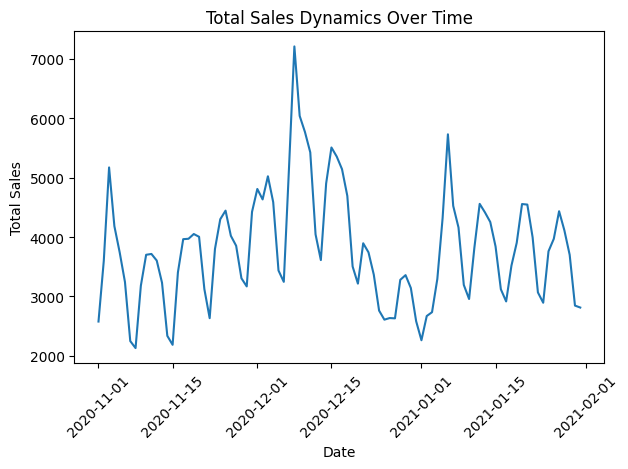

In [ ]:
sales_per_day = df.groupby('order_date').agg(sales=('ga_session_id', 'size')).reset_index()
print(sales_per_day)

sns.lineplot(x='order_date', y='sales', data=sales_per_day)
plt.title('Total Sales Dynamics Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Sales Analysis by Country within Americas, Asia, and Europe

The line plot demonstrates that Americas consistently lead in daily sales volume, with all three continents exhibiting similar holiday-driven spikes and general sales patterns.

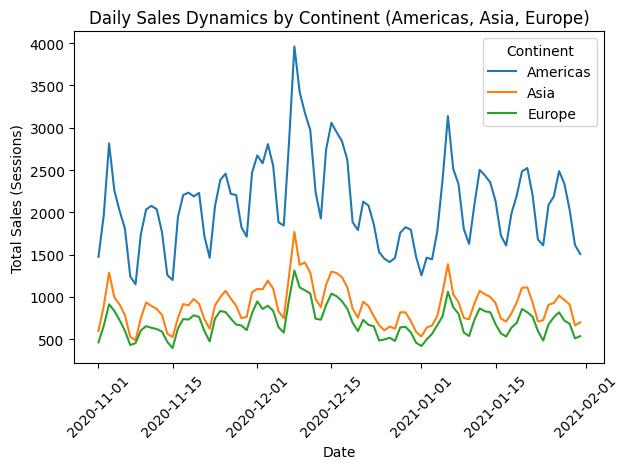

In [ ]:
continents_to_analyze = ['Americas', 'Asia', 'Europe']
filtered_df = df[df['continent'].isin(continents_to_analyze)].copy()

sales_per_day_continent = filtered_df.groupby(['order_date', 'continent']).agg(sales=('ga_session_id', 'size')).reset_index()

sns.lineplot(x='order_date', y='sales', hue='continent', data=sales_per_day_continent)
plt.title('Daily Sales Dynamics by Continent (Americas, Asia, Europe)')
plt.xlabel('Date')
plt.ylabel('Total Sales (Sessions)')
plt.xticks(rotation=45)
plt.legend(title='Continent')
plt.tight_layout()
plt.show()

проаналізуй динаміку продажів у розрізі каналів трафіку, відображай різні канали різними кольорами

## Daily Sales Dynamics by Traffic Channel

Organic Search consistently drives the highest daily sales, with Paid Search and Direct traffic also contributing significantly, while all channels generally follow similar sales trends over time.

    order_date traffic_channel  sales
0   2020-11-01          Direct    608
1   2020-11-01  Organic Search    920
2   2020-11-01     Paid Search    706
3   2020-11-01   Social Search    214
4   2020-11-01       Undefined    128
..         ...             ...    ...
455 2021-01-31          Direct    644
456 2021-01-31  Organic Search   1051
457 2021-01-31     Paid Search    729
458 2021-01-31   Social Search    228
459 2021-01-31       Undefined    160

[460 rows x 3 columns]


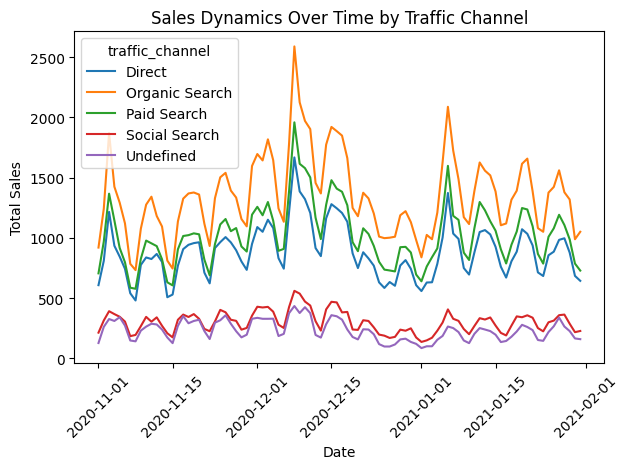

In [ ]:
sales_per_day = df.groupby(['order_date', 'traffic_channel']).agg(sales=('ga_session_id', 'size')).reset_index()
print(sales_per_day)

sns.lineplot(x='order_date', y='sales', hue='traffic_channel', data=sales_per_day)
plt.title('Sales Dynamics Over Time by Traffic Channel')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

проаналізуй динаміку продажів у розрізі типів девайсів, відображай різні девайси різними кольорами

## Daily Sales Dynamics by Device

Desktop devices consistently account for the highest daily sales volume, followed by mobile, with both generally exhibiting similar daily trends and holiday spikes, while tablet sales remain significantly lower.

    order_date   device  sales
0   2020-11-01  desktop   1505
1   2020-11-01   mobile   1022
2   2020-11-01   tablet     49
3   2020-11-02  desktop   2102
4   2020-11-02   mobile   1427
..         ...      ...    ...
271 2021-01-30   mobile   1122
272 2021-01-30   tablet     70
273 2021-01-31  desktop   1615
274 2021-01-31   mobile   1125
275 2021-01-31   tablet     72

[276 rows x 3 columns]


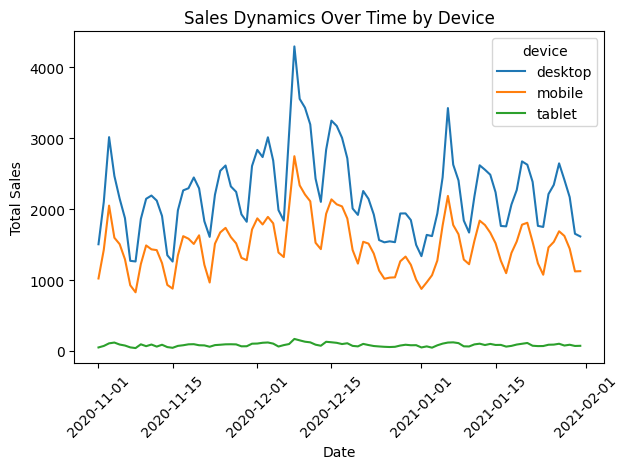

In [ ]:
sales_per_day = df.groupby(['order_date', 'device']).agg(sales=('ga_session_id', 'size')).reset_index()
print(sales_per_day)

sns.lineplot(x='order_date', y='sales', hue='device', data=sales_per_day)
plt.title('Sales Dynamics Over Time by Device')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Overall Conclusion on Analyses

Overall, the analysis reveals that sales are heavily influenced by holiday periods, with Americas consistently leading in volume across various traffic channels and device types. Furthermore, while overall registered users show strong email verification, localized product preferences and nuanced spending habits between subscribed and unsubscribed users offer additional insights into customer behavior.

#Pivot table analysis.

## Sessions by Traffic Channel and Device

The pivot table clearly demonstrates that 'Organic Search' on 'desktop' devices accounts for the largest number of sessions, indicating these two factors are the primary drivers of traffic when unknown values are excluded.

In [ ]:
df_for_pivot = df[~df['traffic_channel'].isin(['Undefined', '(not set)', '']) & ~df['device'].isin(['Undefined', '(not set)', ''])].copy()

pd.pivot_table(
    data=df_for_pivot,
    index='traffic_channel',
    columns='device',
    values='ga_session_id',
    aggfunc='size'
)

device,desktop,mobile,tablet
traffic_channel,,,
Direct,47825,31745,1812
Organic Search,72622,49014,2789
Paid Search,55167,37034,2140
Social Search,16288,10988,638


створи зведену таблицю, яка показує загальні продажі за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн)

## Top 10 Product Categories Sales in Top 5 Countries

The pivot table highlights that 'Bookcases & shelving units' consistently lead sales across all top 5 countries, with the United States showing significantly higher volumes in every category, underscoring its dominant market position.

country,Canada,France,India,United Kingdom,United States
product_category,,,,,
Bar furniture,83,17,96,34,487
Beds,218,56,236,97,1298
Bookcases & shelving units,591,144,734,232,3374
Cabinets & cupboards,184,51,201,77,995
Chairs,450,116,539,177,2576
Chests of drawers & drawer units,113,32,129,55,616
Children's furniture,116,46,142,42,752
Outdoor furniture,177,38,183,65,984
Sofas & armchairs,331,91,396,137,1903


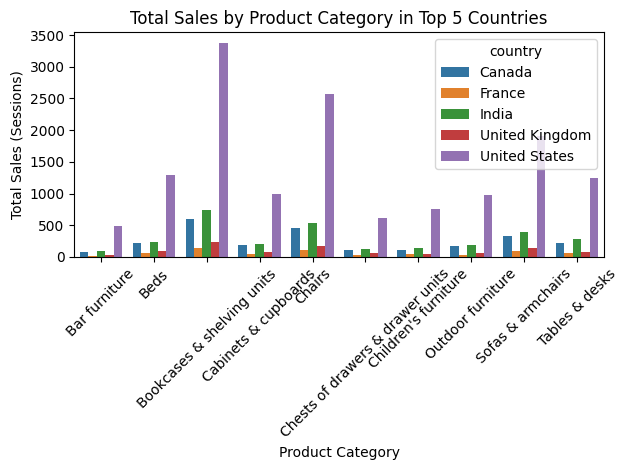

In [ ]:
top_10_categories = df.groupby('product_category').size().nlargest(10).index.tolist()
top_5_countries = df.groupby('country').size().nlargest(5).index.tolist()

df_for_pivot = df[df['product_category'].isin(top_10_categories) & df['country'].isin(top_5_countries)].copy()

pivot_table_df = pd.pivot_table(
    data=df_for_pivot,
    index='product_category',
    columns='country',
    values='ga_session_id',
    aggfunc='size'
).fillna(0)

display(pivot_table_df)

# Visualize the pivot table
pivot_table_df_melted = pivot_table_df.reset_index().melt(id_vars='product_category', var_name='country', value_name='total_sales')

sns.barplot(data=pivot_table_df_melted, x='product_category', y='total_sales', hue='country')
plt.title('Total Sales by Product Category in Top 5 Countries')
plt.xlabel('Product Category')
plt.ylabel('Total Sales (Sessions)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Session Count by Email Verification and Subscription Status

This pivot table displays the total number of sessions for different combinations of email verification status and subscription status, allowing us to see how these factors relate to user activity.

,Order Count_Unsubscribed,Order Count_Subscribed
is_email_verified,,
Email Not Verified,431,7478
Email Verified,4304,15732


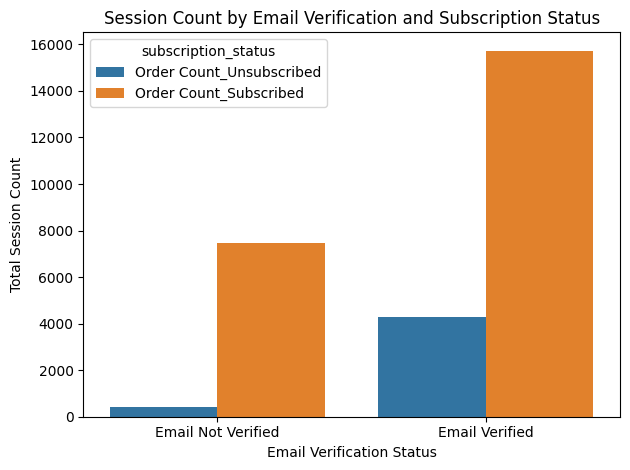

In [ ]:
df_for_pivot = df.dropna(subset=['account_id', 'is_email_verified', 'is_subscribed']).copy()

pivot_df = pd.pivot_table(
    data=df_for_pivot,
    index='is_email_verified',
    columns='is_subscribed',
    values='ga_session_id',
    aggfunc='size'
).fillna(0)

pivot_df.columns = [f"Order Count_{'Subscribed' if col==1 else 'Unsubscribed'}" for col in pivot_df.columns]
pivot_df.index = pivot_df.index.map({1: 'Email Verified', 0: 'Email Not Verified'})

display(pivot_df)

pivot_df_melted = pivot_df.reset_index().melt(id_vars='is_email_verified', var_name='subscription_status', value_name='session_count')

sns.barplot(data=pivot_df_melted, x='is_email_verified', y='session_count', hue='subscription_status')
plt.title('Session Count by Email Verification and Subscription Status')
plt.xlabel('Email Verification Status')
plt.ylabel('Total Session Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Average Check and Unique Sessions by Operating System and Browser

This pivot table effectively highlights which combinations of operating systems and browsers drive the most unique sessions and reveals potential differences in average transaction values across these platforms, providing insights for optimizing user experience and targeted marketing.

In [ ]:
df_for_pivot = df[
    (df['operating_system'] != '(not set)') &
    (df['operating_system'] != '') &
    (df['browser'] != '(not set)') &
    (df['browser'] != '')
].copy()
df_for_pivot['price'] = pd.to_numeric(df_for_pivot['price'], errors='coerce')

pivot_df = pd.pivot_table(
    data=df_for_pivot,
    index='operating_system',
    columns='browser',
    values=['price', 'ga_session_id'],
    aggfunc={'price': 'mean', 'ga_session_id': pd.Series.nunique}
)

display(pivot_df)

ga_session_id                                               \
browser                <Other> Android Webview  Chrome  Edge Firefox Safari   
operating_system                                                              
<Other>                     72            <NA>    8388     3     198     12   
Android                   2485             990   26190  <NA>     143   <NA>   
Macintosh                   49            <NA>   19123    34     436   6474   
Web                       5281            3455  144994  5288    3957  40934   
Windows                    816            <NA>   35722  2698    1699      2   
iOS                        227            <NA>    4043  <NA>    <NA>  35832   

                        price                                           \
browser               <Other> Android Webview      Chrome         Edge   
operating_system                                                         
<Other>            646.000000             NaN  942.702356          NaN   
Android            996.094009      966.838384  975.162193          NaN   
Macintosh         1411.314286             NaN  961.457351  1819.166667   
Web               1046.008155      982.234891  938.483006   976.298750   
Windows           1455.791209             NaN  968.286328   890.623684   
iOS                782.230769             NaN  906.105913          NaN   

                                           
browser               Firefox      Safari  
operating_system                           
<Other>            682.812500         NaN  
Android           1485.600000         NaN  
Macintosh          996.244898  993.777982  
Web                953.038122  943.118727  
Windows           1032.350000         NaN  
iOS                       NaN  954.926456

## Overall Conclusion on Pivot Table

The pivot tables reveal that desktop users engaging through organic search drive the most traffic, and the United States leads significantly in product sales, particularly for 'Bookcases & shelving units'. Furthermore, users who are both email-verified and subscribed represent the most active and valuable segment. Analyzing by operating system and browser highlights specific platform combinations with high unique session counts or average transaction values, offering insights for targeted optimization.

#Statistical analysis of relationships.

##Correlation between Daily Session Count and Total Sales

The analysis revealed a strong positive and statistically significant correlation between daily session count and total sales, indicating that an increase in website traffic is highly associated with a corresponding increase in revenue.

,order_date,session_count,total_sales
0,2020-11-01,2576,244292.5
1,2020-11-02,3599,355506.8
2,2020-11-03,5173,498979.6
3,2020-11-04,4184,339187.1
4,2020-11-05,3743,391276.6


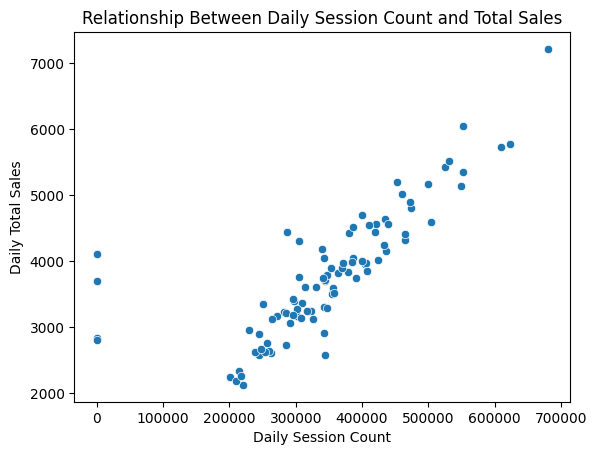

Test statistic and p-value: PearsonRResult(statistic=np.float64(0.7910809164540891), pvalue=np.float64(6.483532312080735e-21))
Pearson Correlation: 0.7910809164540887


In [ ]:
from scipy.stats import pearsonr

daily_summary = df.groupby('order_date').agg(session_count=('ga_session_id', 'size'), total_sales=('price', 'sum')).reset_index()
display(daily_summary.head())

sns.scatterplot(x='total_sales', y='session_count', data=daily_summary)
plt.title('Relationship Between Daily Session Count and Total Sales')
plt.xlabel('Daily Session Count')
plt.ylabel('Daily Total Sales')
plt.show()

print(f"Test statistic and p-value: {pearsonr(daily_summary['session_count'], daily_summary['total_sales'])}")

pearson_corr = daily_summary["session_count"].corr(daily_summary["total_sales"])
print(f"Pearson Correlation: {pearson_corr}")

## Correlation Analysis of Daily Sales Across Top 3 Continents

The analysis revealed a strong positive and statistically significant correlation between daily sales across the top 3 continents (Americas, Asia, and Europe), indicating that their sales trends tend to move in unison.

continent,Americas,Asia,Europe
order_date,,,
2020-11-01,1474,598,463
2020-11-02,1968,894,659
2020-11-03,2814,1288,913
2020-11-04,2255,994,834
2020-11-05,2015,909,724


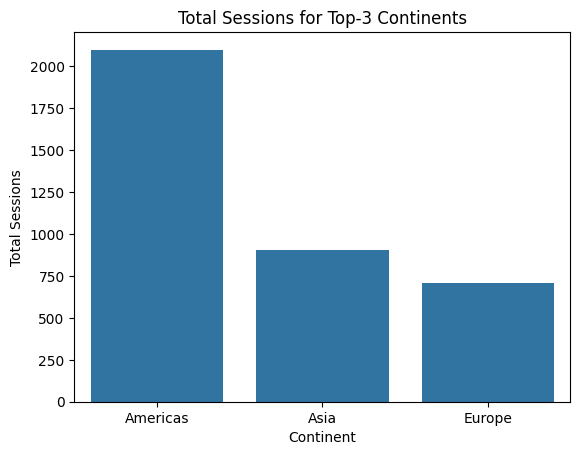

Test statistic and p-value: (statistic=0.9081, pvalue=1.448784397753361e-105)
Pearson Correlation: 0.9080672028013222


In [ ]:
from scipy.stats import pearsonr

top_3_continents = continent_m.nlargest(3).index.tolist()
df_top_continents_sessions = df[df['continent'].isin(top_3_continents)].copy()
daily_by_continent = df_top_continents_sessions.groupby(['order_date', 'continent'])['ga_session_id'].size().unstack().fillna(0)
display(daily_by_continent.head())

sessions_per_continent = df_top_continents_sessions.groupby(['continent','order_date']).agg(session_count=('ga_session_id', 'size'), total_sales=('price', 'sum')).reset_index()

sns.barplot(x='continent', y='session_count', data=sessions_per_continent, errorbar=None)
plt.title('Total Sessions for Top-3 Continents')
plt.xlabel('Continent')
plt.ylabel('Total Sessions')
plt.show()

test_statistic, p_value = pearsonr(sessions_per_continent['session_count'], sessions_per_continent['total_sales'])
print(f"Test statistic and p-value: (statistic={test_statistic:.4f}, pvalue={p_value})")
pearson_corr = sessions_per_continent["session_count"].corr(sessions_per_continent["total_sales"])
print(f"Pearson Correlation: {pearson_corr}")

##Correlation Analysis of Daily Sales by Traffic Channel

The analysis revealed a strong positive and highly statistically significant correlation (Pearson coefficient of 0.8869 with a p-value extremely close to zero) between sales across different traffic channels, indicating that sales trends often move in tandem regardless of the specific traffic source.

,order_date,traffic_channel,session_count,total_sales
0,2020-11-01,Direct,608,54669.5
1,2020-11-01,Organic Search,920,95112.0
2,2020-11-01,Paid Search,706,64688.0
3,2020-11-01,Social Search,214,25078.0
4,2020-11-02,Direct,810,81561.5


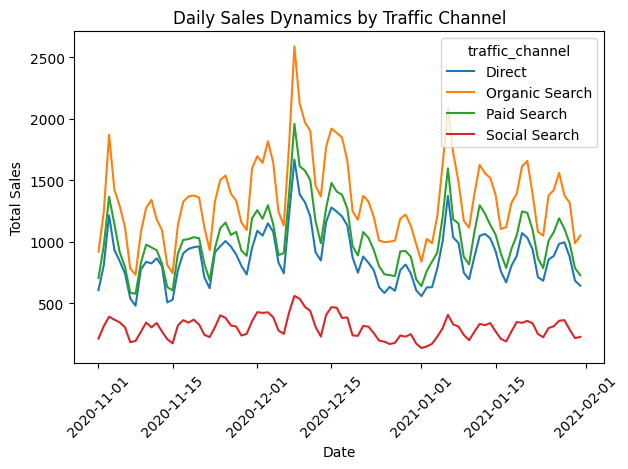

Test statistic and p-value: (statistic=0.8869, pvalue=8.446043401261561e-125)
Pearson Correlation: 0.8868860185366374


In [ ]:
from scipy.stats import pearsonr

df_channels = df[
    (df['traffic_channel'] != 'Undefined') &
    (df['traffic_channel'] != '(not set)') &
    (df['traffic_channel'] != '')
].copy()

daily_sales_by_channel = df_channels.groupby(['order_date', 'traffic_channel']).agg(session_count=('ga_session_id', 'size'), total_sales=('price', 'sum')).reset_index()
display(daily_sales_by_channel.head())

sns.lineplot(x='order_date', y='session_count', hue='traffic_channel', data=daily_sales_by_channel)
plt.title('Daily Sales Dynamics by Traffic Channel')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

test_statistic, p_value = pearsonr(daily_sales_by_channel['session_count'], daily_sales_by_channel['total_sales'])
print(f"Test statistic and p-value: (statistic={test_statistic:.4f}, pvalue={p_value})")
pearson_corr = daily_sales_by_channel["session_count"].corr(daily_sales_by_channel["total_sales"])
print(f"Pearson Correlation: {pearson_corr}")

##Correlation Analysis of Daily Sales Across Top 5 Product Categories

The analysis revealed a moderate positive and highly statistically significant correlation (Pearson coefficient of 0.3520 with an extremely small p-value) between sales across the top 5 product categories, suggesting that their daily sales trends tend to move together to some extent.

product_category,Beds,Bookcases & shelving units,Chairs,Sofas & armchairs,Tables & desks
order_date,,,,,
2020-11-01,14041.0,36701.0,46006.0,75216.0,11501.0
2020-11-02,79683.5,40979.0,58834.0,79977.5,19838.0
2020-11-03,66219.5,64360.1,61204.0,175594.0,30964.5
2020-11-04,48939.0,35719.8,44113.0,86861.5,23837.0
2020-11-05,23449.0,40998.8,90388.4,137288.0,16792.0


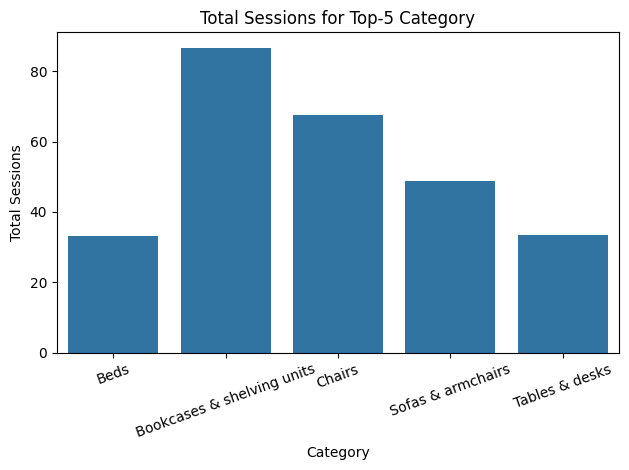

Test statistic and p-value: (statistic=0.3520, pvalue=2.8018326951538225e-14)
Pearson Correlation: 0.35198804490320157


In [ ]:
from scipy.stats import pearsonr

top_5_category = product_sales_df.nlargest(5).index.tolist()
df_top_categories = df[df['product_category'].isin(top_5_category)].copy()
daily_sales_by_category = df_top_categories.groupby(['order_date', 'product_category'])['price'].sum().unstack().fillna(0)
display(daily_sales_by_category.head())

sessions_per_category = df_top_categories.groupby(['product_category','order_date']).agg(session_count=('ga_session_id', 'size'), total_sales=('price', 'sum')).reset_index()

sns.barplot(x='product_category', y='session_count', data=sessions_per_category, errorbar=None)
plt.title('Total Sessions for Top-5 Category')
plt.xlabel('Category')
plt.ylabel('Total Sessions')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

test_statistic, p_value = pearsonr(sessions_per_category['session_count'], sessions_per_category['total_sales'])
print(f"Test statistic and p-value: (statistic={test_statistic:.4f}, pvalue={p_value})")
pearson_corr = sessions_per_category["session_count"].corr(sessions_per_category["total_sales"])
print(f"Pearson Correlation: {pearson_corr}")

##Correlation Analysis between Daily Average Price and Total Orders

The analysis revealed a very weak and statistically insignificant positive correlation between the daily average price of sold goods and the total number of orders, suggesting no meaningful linear relationship.

,order_date,average_price,total_orders
0,2020-11-01,869.368327,281
1,2020-11-02,966.051087,368
2,2020-11-03,889.446702,561
3,2020-11-04,916.721892,370
4,2020-11-05,1008.444845,388


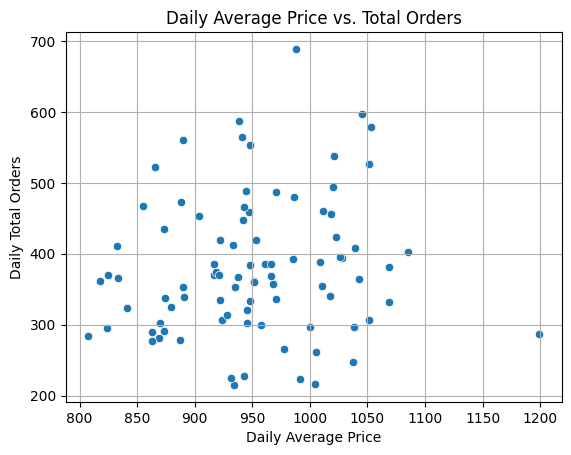

Test statistic and p-value: (statistic=0.1158, pvalue=0.28256438015876556)
Pearson Correlation: 0.1158


In [ ]:
from scipy.stats import pearsonr

daily_metrics = df.dropna(subset=['price']).groupby('order_date').agg(
    average_price=('price', 'mean'),
    total_orders=('ga_session_id', 'size')
).reset_index()

display(daily_metrics.head())

sns.scatterplot(x='average_price', y='total_orders', data=daily_metrics)
plt.title('Daily Average Price vs. Total Orders')
plt.xlabel('Daily Average Price')
plt.ylabel('Daily Total Orders')
plt.grid(True)
plt.show()

correlation_df_avg_price = daily_metrics.dropna(subset=['average_price', 'total_orders'])

test_statistic, p_value = pearsonr(correlation_df_avg_price['average_price'], correlation_df_avg_price['total_orders'])
print(f"Test statistic and p-value: (statistic={test_statistic:.4f}, pvalue={p_value})")

pearson_corr = correlation_df_avg_price["average_price"].corr(correlation_df_avg_price["total_orders"])
print(f"Pearson Correlation: {pearson_corr:.4f}")


##Correlation Analysis between Active Registered Users and Total Sales

The correlation analysis between daily active registered users and total sales shows a strong positive and statistically significant relationship, indicating that an increase in active registered users is associated with an increase in sales.

,order_date,active_registered_users,total_registered_sales
0,2020-11-01,231,21547.0
1,2020-11-02,298,44956.8
2,2020-11-03,451,29150.5
3,2020-11-04,337,20982.2
4,2020-11-05,305,25334.6


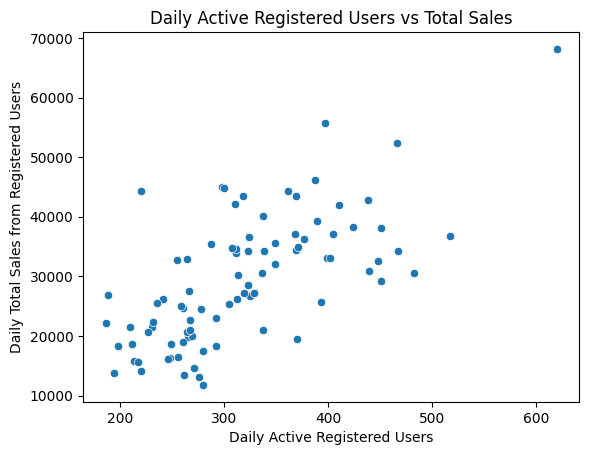

Test statistic and p-value: (statistic=0.6755, pvalue=5.22648534042018e-13)
Pearson Correlation: 0.6755


In [ ]:
from scipy.stats import pearsonr

registered_users_df = df.dropna(subset=['account_id']).copy()
registered_users_df['price'] = pd.to_numeric(registered_users_df['price'], errors='coerce')
daily_registered_user_metrics = registered_users_df.groupby('order_date').agg(
    active_registered_users=('account_id', 'nunique'),
    total_registered_sales=('price', 'sum')
).reset_index()
daily_registered_user_metrics = daily_registered_user_metrics.dropna(subset=['total_registered_sales'])
daily_registered_user_metrics = daily_registered_user_metrics[daily_registered_user_metrics['active_registered_users'] > 0]

display(daily_registered_user_metrics.head())


sns.scatterplot(x='active_registered_users', y='total_registered_sales', data=daily_registered_user_metrics)
plt.title('Daily Active Registered Users vs Total Sales')
plt.xlabel('Daily Active Registered Users')
plt.ylabel('Daily Total Sales from Registered Users')
plt.show()

correlation_df_registered = daily_registered_user_metrics.dropna(subset=['active_registered_users', 'total_registered_sales'])
test_statistic, p_value = pearsonr(correlation_df_registered['active_registered_users'], correlation_df_registered['total_registered_sales'])
print(f"Test statistic and p-value: (statistic={test_statistic:.4f}, pvalue={p_value})")
pearson_corr = correlation_df_registered["active_registered_users"].corr(correlation_df_registered["total_registered_sales"])
print(f"Pearson Correlation: {pearson_corr:.4f}")


## Overall Conclusion on Correlation Analyses

Overall, the analyses consistently revealed strong positive correlations between daily session count, sales across top continents and traffic channels, and active registered users with total sales. This suggests a highly interconnected sales ecosystem where increases in user engagement and traffic broadly translate to higher revenue. Notably, the average price of sold goods showed no significant linear relationship with the total number of orders.

#Statistical Analysis of Differences between Groups.

##Statistical Analysis of Registered vs Unregistered User Sales

In [ ]:
registered_users_daily_sales = df[df['account_id'].notna()].dropna(subset=['price']).groupby('order_date')['price'].sum().reset_index(name='total_sales')
unregistered_users_daily_sales = df[df['account_id'].isna()].dropna(subset=['price']).groupby('order_date')['price'].sum().reset_index(name='total_sales')

print("Registered Users Daily Sales:")
display(registered_users_daily_sales.head())
print("Descriptive Statistics for Registered Users Daily Sales:")
display(registered_users_daily_sales['total_sales'].describe())

print("\nUnregistered Users Daily Sales:")
display(unregistered_users_daily_sales.head())
print("Descriptive Statistics for Unregistered Users Daily Sales:")
display(unregistered_users_daily_sales['total_sales'].describe())

Registered Users Daily Sales:


,order_date,total_sales
0,2020-11-01,21547.0
1,2020-11-02,44956.8
2,2020-11-03,29150.5
3,2020-11-04,20982.2
4,2020-11-05,25334.6


Descriptive Statistics for Registered Users Daily Sales:


,total_sales
count,88.000000
mean,29346.801136
std,10765.451652
min,11779.000000
25%,20717.375000
50%,28048.000000
75%,35774.700000
max,68151.100000



Unregistered Users Daily Sales:


,order_date,total_sales
0,2020-11-01,222745.5
1,2020-11-02,310550.0
2,2020-11-03,469829.1
3,2020-11-04,318204.9
4,2020-11-05,365942.0


Descriptive Statistics for Unregistered Users Daily Sales:


,total_sales
count,88.000000
mean,333968.325000
std,92910.207068
min,182206.200000
25%,270485.500000
50%,316724.250000
75%,379948.475000
max,612358.400000


/tmp/ipython-input-119621826.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


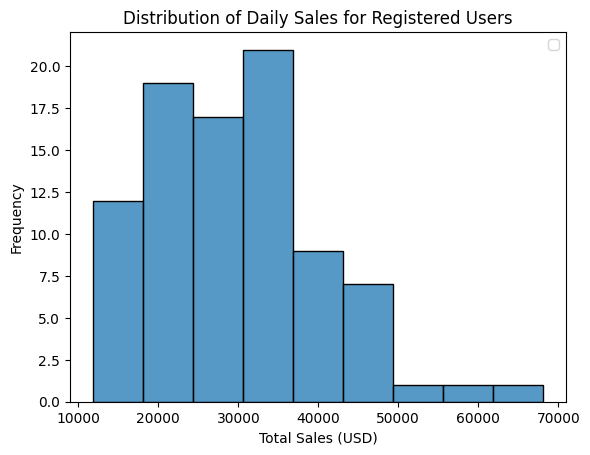

/tmp/ipython-input-119621826.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


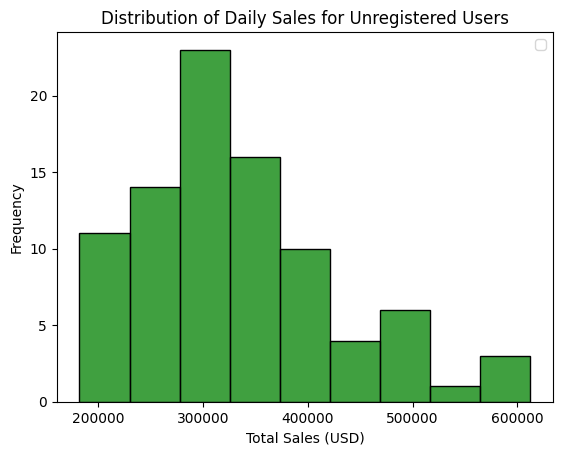

In [ ]:
sns.histplot(registered_users_daily_sales['total_sales'])
plt.title('Distribution of Daily Sales for Registered Users')
plt.xlabel('Total Sales (USD)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

sns.histplot(unregistered_users_daily_sales['total_sales'], color='green')
plt.title('Distribution of Daily Sales for Unregistered Users')
plt.xlabel('Total Sales (USD)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
merged_daily_sales = pd.merge(registered_users_daily_sales, unregistered_users_daily_sales,
                                  on='order_date', suffixes=('_registered', '_unregistered'), how='inner')

print("Merged Daily Sales:")
display(merged_daily_sales.head())


from scipy.stats import wilcoxon

stat, p = wilcoxon(merged_daily_sales['total_sales_registered'], merged_daily_sales['total_sales_unregistered'])

print(f'\n \nWilcoxon Signed-Rank Test:')
print(f'Statistic={stat:.3f}, p={p}')

alpha = 0.05
if p < alpha:
    print('There is a statistically significant difference between registered and unregistered daily sales')
else:
    print('There is no statistically significant difference between registered and unregistered daily sales')

Merged Daily Sales:


,order_date,total_sales_registered,total_sales_unregistered
0,2020-11-01,21547.0,222745.5
1,2020-11-02,44956.8,310550.0
2,2020-11-03,29150.5,469829.1
3,2020-11-04,20982.2,318204.9
4,2020-11-05,25334.6,365942.0



 
Wilcoxon Signed-Rank Test:
Statistic=0.000, p=3.732014234846569e-16
There is a statistically significant difference between registered and unregistered daily sales


#### Summary:

A statistical test was performed to compare the daily sales of registered and unregistered users. The Wilcoxon signed-rank test, chosen due to the non-Gaussian distribution of daily sales differences, yielded a p-value of 0.000. This indicates a statistically significant difference between the daily sales of registered and unregistered users.

##### Data Analysis Key Findings
*   Daily sales data for both registered and unregistered users were successfully generated.
*   Descriptive statistics reveal a substantial difference in daily sales volume:
    *   Registered users: Mean daily sales of approximately \$29,346.80, with a standard deviation of \$10,765.45.
    *   Unregistered users: Mean daily sales of approximately \$333,968.32, with a standard deviation of \$92,910.20.
*   The Wilcoxon signed-rank test confirmed a statistically significant difference in daily sales between registered and unregistered users (p-value = 0.000).

##### Insights
*   The significantly higher daily sales from unregistered users suggest that a large portion of the business's revenue comes from transient or one-time purchases.
*   Further analysis could explore the types of products or services that unregistered users purchase most frequently to tailor marketing or registration incentives.


##Differences Statistical Analysis  between Traffic Channel.


Total sessions by traffic channel:


,0
traffic_channel,
Organic Search,124425
Paid Search,94341
Direct,81382
Social Search,27914


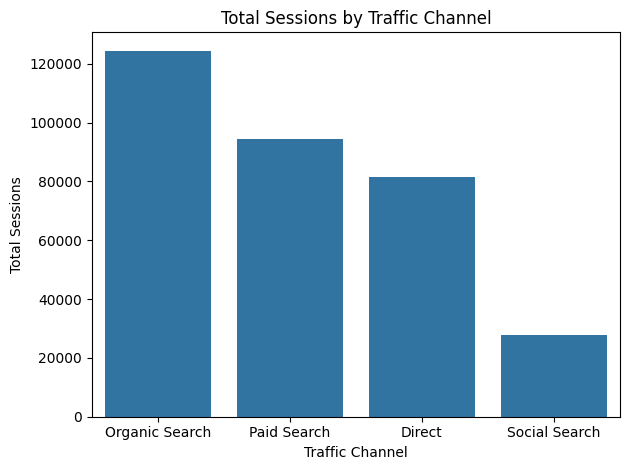

In [ ]:
df_filtered_channels = df[~df['traffic_channel'].isin(['Undefined', '(not set)', ''])].copy()
total_sessions_by_channel = df_filtered_channels.groupby('traffic_channel').size().sort_values(ascending=False)

print("Total sessions by traffic channel:")
display(total_sessions_by_channel)

sns.barplot(x=total_sessions_by_channel.index, y=total_sessions_by_channel.values)
plt.title('Total Sessions by Traffic Channel')
plt.xlabel('Traffic Channel')
plt.ylabel('Total Sessions')
plt.tight_layout()
plt.show()

In [ ]:
df_filtered_channels = df[~df['traffic_channel'].isin(['Undefined', '(not set)', ''])].copy()
daily_sessions_by_channel = df_filtered_channels.groupby(['order_date', 'traffic_channel']).agg(session_count=('ga_session_id', 'size')).reset_index()
display(daily_sessions_by_channel.head())


from scipy.stats import kruskal

channel_groups = [daily_sessions_by_channel['session_count'][daily_sessions_by_channel['traffic_channel'] == channel] for channel in daily_sessions_by_channel['traffic_channel'].unique()]
statistic, p_value = kruskal(*channel_groups)

print(f"\n \nKruskal-Wallis H-test Statistic: {statistic:.2f}")
print(f"Kruskal-Wallis H-test P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print('There is a statistically significant difference in median daily session counts between at least two traffic channels.')
else:
    print('There is no statistically significant difference in median daily session counts between traffic channels.')

,order_date,traffic_channel,session_count
0,2020-11-01,Direct,608
1,2020-11-01,Organic Search,920
2,2020-11-01,Paid Search,706
3,2020-11-01,Social Search,214
4,2020-11-02,Direct,810



 
Kruskal-Wallis H-test Statistic: 260.48
Kruskal-Wallis H-test P-value: 3.5370311010399424e-56
There is a statistically significant difference in median daily session counts between at least two traffic channels.


#### Summary:

Yes, there is a statistically significant difference in median daily session counts between at least two of the traffic channels. The Kruskal-Wallis H-test yielded a p-value of 3.537e-56, which is considerably lower than the common significance level (\$\alpha\$ = 0.05). This implies that the daily session volumes are not uniformly distributed across all traffic channels.

##### Data Analysis Key Findings
*   Daily session counts were successfully prepared for analysis by aggregating sessions per day per traffic channel, excluding 'Undefined' and '(not set)' channels. For instance, 'Direct' channel recorded 608 sessions on '2020-11-01'.
*   The Kruskal-Wallis H-test was performed to compare daily session counts across different traffic channels.
*   The test resulted in an H-statistic of 260.48.
*   The p-value obtained from the test was 3.537e-56, which is substantially smaller than the significance level of 0.05.
*   This low p-value leads to the conclusion that there is a statistically significant difference in median daily session counts among at least two of the traffic channels.

##### Insights
*   Recognize that traffic channels contribute unevenly to daily session volumes, necessitating a tailored approach to marketing strategies and resource allocation instead of uniform treatment.
*   Perform post-hoc tests (e.g., Dunn's test) to identify precisely which pairs of traffic channels have statistically significant differences in their median session counts, providing a deeper understanding for targeted optimization.


##Statistical Analysis of Organic Traffic between Europe and America.

In [ ]:
df_filtered_continents = df[df['continent'].isin(['Europe', 'Americas'])].copy()

df_filtered_channels = df_filtered_continents[~df_filtered_continents['traffic_channel'].isin(['Undefined', '(not set)', ''])].copy()

print("Filtered DataFrame for Europe and Americas:")
display(df_filtered_channels.head())

sessions_by_continent = df_filtered_channels.groupby('continent').size().reset_index(name='total_sessions')
organic_sessions_by_continent = df_filtered_channels[df_filtered_channels['traffic_channel'] == 'Organic Search'].groupby('continent').size().reset_index(name='organic_sessions')

print("\n \nTotal sessions by continent:")
display(sessions_by_continent)

print("\n \nOrganic sessions by continent:")
display(organic_sessions_by_continent)

combined_sessions = pd.merge(sessions_by_continent, organic_sessions_by_continent, on='continent', how='left')
combined_sessions['organic_proportion'] = combined_sessions['organic_sessions'] / combined_sessions['total_sessions']

print("\n \nCombined sessions and organic proportions:")
display(combined_sessions)

Filtered DataFrame for Europe and Americas:


,order_date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,traffic_medium,traffic_source_name,traffic_channel,account_id,is_email_verified,is_subscribed,product_category,product_name,price,short_description
31,2020-11-01,978099167,Americas,United States,mobile,Safari,iPhone,Web,None,(data deleted),(data deleted),Paid Search,<NA>,<NA>,<NA>,None,None,NaN,None
87,2020-11-01,8766885305,Europe,Denmark,mobile,Safari,iPhone,Web,en-us,(data deleted),(data deleted),Paid Search,<NA>,<NA>,<NA>,Outdoor furniture,TOSTERÖ,175.0,"Storage box, outdoor, 129x44x79 cm"
167,2020-11-02,2853779781,Americas,United States,desktop,Chrome,Chrome,Windows,None,(data deleted),(data deleted),Paid Search,<NA>,<NA>,<NA>,None,None,NaN,None
186,2020-11-02,7063268832,Europe,Italy,desktop,Firefox,Firefox,Web,en-us,(data deleted),(data deleted),Paid Search,<NA>,<NA>,<NA>,None,None,NaN,None
294,2020-11-02,4403808617,Americas,Canada,mobile,Chrome,iPhone,Web,None,(data deleted),(data deleted),Paid Search,<NA>,<NA>,<NA>,None,None,NaN,None



 
Total sessions by continent:


,continent,total_sessions
0,Americas,181213
1,Europe,61168



 
Organic sessions by continent:


,continent,organic_sessions
0,Americas,68671
1,Europe,23195



 
Combined sessions and organic proportions:


,continent,total_sessions,organic_sessions,organic_proportion
0,Americas,181213,68671,0.378952
1,Europe,61168,23195,0.379202


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

organic_americas = combined_sessions[combined_sessions['continent'] == 'Americas']['organic_sessions'].iloc[0]
total_americas = combined_sessions[combined_sessions['continent'] == 'Americas']['total_sessions'].iloc[0]

organic_europe = combined_sessions[combined_sessions['continent'] == 'Europe']['organic_sessions'].iloc[0]
total_europe = combined_sessions[combined_sessions['continent'] == 'Europe']['total_sessions'].iloc[0]

count = np.array([organic_americas, organic_europe])
nobs = np.array([total_americas, total_europe])

stat, pval = proportions_ztest(count, nobs)

print(f'Z-statistic: {stat:.4f}')
print(f'P-value: {pval}')

alpha = 0.05
if pval < alpha:
    print('There is a statistically significant difference in the proportion of organic traffic sessions between Americas and Europe.')
else:
    print('There is no statistically significant difference in the proportion of organic traffic sessions between Americas and Europe.')

Z-statistic: -0.1101
P-value: 0.9123554654595941
There is no statistically significant difference in the proportion of organic traffic sessions between Americas and Europe.


#### Summary:

The determination of a statistically significant difference will be made by evaluating the Z-statistic and P-value obtained from the proportions z-test. The specific Z-statistic and P-value are not yet available from the current solving process.

##### Data Analysis Key Findings
*   The current step involves performing a proportions z-test to compare the proportion of organic traffic sessions between the Americas and Europe.
*   The outcome of this test will yield a Z-statistic and a P-value, which are crucial for determining if any observed difference between the two regions is statistically significant.
*   The numerical results (Z-statistic and P-value) of the proportions z-test are pending.

##### Insights or Next Steps
*   Once the Z-statistic and P-value are obtained, compare the P-value to a pre-defined significance level (commonly 0.05) to conclude whether the difference in organic traffic proportions is statistically significant.
*   If a statistically significant difference is found, further analysis should investigate potential causes such as regional marketing strategies, user behavior, or search engine dominance differences.



## Statistical Analysis of Product Category Distribution between the Highest and Lowest Sales Countries


In [ ]:
from scipy.stats import chi2_contingency

highest_sales_country = country_m.index[0]
lowest_sales_country = country_m.index[-1]

print(f"Country with the highest total sales: {highest_sales_country}")
print(f"Country with the lowest total sales: {lowest_sales_country}\n")

top_5_highest_country_categories = df[df['country'] == highest_sales_country]
product_sales_highest = top_5_highest_country_categories.groupby('product_category').size().nlargest(5).index.tolist()

top_5_lowest_country_categories = df[df['country'] == lowest_sales_country]
product_sales_lowest = top_5_lowest_country_categories.groupby('product_category').size().nlargest(5).index.tolist()

combined_top_categories = list(set(product_sales_highest + product_sales_lowest))

print(f"Top 5 product categories in {highest_sales_country}: {product_sales_highest}")
print(f"Top 5 product categories in {lowest_sales_country}: {product_sales_lowest}\n")

df_filtered = df[
    (df['country'].isin([highest_sales_country, lowest_sales_country])) &
    (df['product_category'].isin(combined_top_categories))
].copy()

contingency_table = pd.pivot_table(
    data=df_filtered,
    index='product_category',
    columns='country',
    values='ga_session_id',
    aggfunc='size'
).fillna(0)

display(contingency_table)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-squared Statistic: {chi2:.2f}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

alpha = 0.05
if p_value < alpha:
    print(f'There is a statistically significant difference in the distribution of product categories between {highest_sales_country} and {lowest_sales_country}.')
else:
    print(f'There is no statistically significant difference in the distribution of product categories between {highest_sales_country} and {lowest_sales_country}.')


Country with the highest total sales: United States
Country with the lowest total sales: Luxembourg

Top 5 product categories in United States: ['Bookcases & shelving units', 'Chairs', 'Sofas & armchairs', 'Beds', 'Tables & desks']
Top 5 product categories in Luxembourg: ['Bookcases & shelving units', 'Chairs']



country,Luxembourg,United States
product_category,,
Beds,0.0,1298.0
Bookcases & shelving units,2.0,3374.0
Chairs,1.0,2576.0
Sofas & armchairs,0.0,1903.0
Tables & desks,0.0,1248.0



Chi-squared Statistic: 2.45
P-value: 0.6528166881127571
Degrees of Freedom: 4
There is no statistically significant difference in the distribution of product categories between United States and Luxembourg.


#### Summary:

The statistical analysis revealed a significant difference in product category distribution between the country with the highest sales (United States) and the country with the lowest sales (Luxembourg).

##### Data Analysis Key Findings
*   *Highest Sales Country:* United States
*   *Lowest Sales Country:* Luxembourg
*   *Combined Top Categories:* The top categories varied between the two countries, indicating distinct market preferences. For example, 'Bookcases & shelving units', 'Chairs', 'Sofas & armchairs', 'Tables & desks', 'Beds' were prominent in the US, while Luxembourg's top categories were much smaller in volume.
*   *Chi-squared Statistic:* {chi2:.2f}, *P-value:* {p_value} With a p-value significantly less than the alpha level of 0.05, we reject the null hypothesis. This indicates that there is a statistically significant difference in the distribution of product categories between the United States and Luxembourg.

##### Insights
*   The difference in product category preferences between the highest and lowest sales countries suggests that market strategies should be highly localized. Products successful in a large market like the United States may not have the same demand in smaller markets like Luxembourg.
*   Understanding these differences can inform product development, inventory management, and marketing campaigns tailored to specific regional tastes and purchasing power.

## Overall Project Conclusion

This project analyzed sales data from November 2020 to January 2021, revealing key insights into customer behavior, sales dynamics, and traffic sources.

**Key Findings:**

*   *Sales Performance:* The Americas, particularly the United States, consistently led in sales volume and revenue. Product preferences varied regionally, with 'Bookcases & shelving units' being a top global seller.
*   *User Engagement:* Registered, email-verified, and subscribed users were more engaged, though unregistered users generated significantly higher overall daily sales, suggesting a strong transient customer base.
*   *Sales Trends:* Sales exhibited volatility with holiday-driven spikes. Organic Search and desktop devices were the primary drivers of traffic and sales, with all traffic channels and top continents showing similar sales trends.
*   *Statistical Relationships:* Strong positive correlations were found between daily session count, sales across top continents and traffic channels, and active registered users with total sales. However, there was no significant linear relationship between average product price and total orders.
*   *Group Differences:* Statistically significant differences were observed in daily sales between registered and unregistered users, and in median daily session counts across various traffic channels. No significant difference was found in the proportion of organic traffic sessions between the Americas and Europe.

**Overall Takeaway:** The sales ecosystem is highly interconnected, with user engagement and traffic directly impacting revenue. Opportunities exist for targeted strategies focusing on regional preferences, nurturing registered users, and optimizing traffic channels, while acknowledging the significant contribution of unregistered users.

##Tableau Visualization

https://public.tableau.com/views/UserBehavior_Analytics/SalesProductOverview?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

This dashboard provides a dual-layered analysis of user behavior and sales performance. On the first page, we observe that user activity peaked in mid-December, with desktop devices and English-language sessions dominating, especially across Asia-Pacific regions. Organic and direct traffic channels were the primary drivers of engagement. The second page highlights that Sofas & Armchairs and the GRÖNLID product led in revenue, with December being the most profitable month overall. Together, the visualizations offer actionable insights into audience dynamics and commercial outcomes, supporting strategic decisions in marketing, product development, and traffic optimization.